In [1]:
"""
this block is needed at the beginning of all notebooks to be able to load modules
"""
import os
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Automatically find and append the project root
root_path = Path.cwd().resolve().parents[1]  # adjust level as needed
data_path = os.path.join(root_path, "data")
src_path = os.path.join(root_path, "src")

if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

In [2]:
from signal_modules.signal_registry import SignalRegistry

In [3]:
signal_registry = SignalRegistry()

In [4]:
signal_registry.available_signals()

['ma_crossover', 'kullman_CUSUM']

In [5]:
model = signal_registry.get('kullman_CUSUM')()

In [6]:
tickers = ['SPY', 'AAPL', 'MSFT', 'SBUX']  # List of tickers
data_files = [os.path.join(data_path, f"{ticker}.parquet") for ticker in tickers]
data = {ticker: pd.read_parquet(path) for ticker, path in zip(tickers, data_files)}

In [7]:
sigs = model.generate_signals(data)

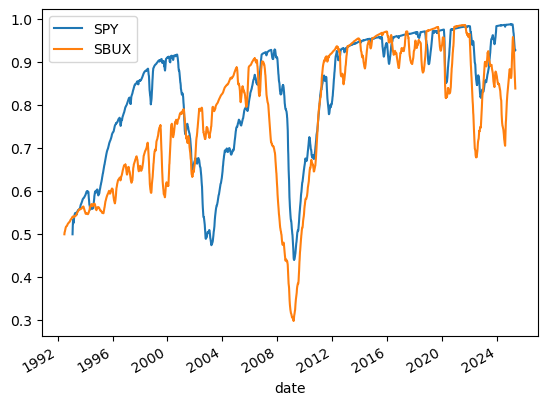

In [9]:
plt.plot()
sigs['SPY'].plot(label='SPY')
sigs['SBUX'].plot(label='SBUX')
plt.legend()
plt.show()